<a href="https://colab.research.google.com/github/xyhan-github/BlogRepo/blob/master/Sparsity_ViTMoE_MSE_CIFAR100_4experts_1layer_highwd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tqdm
import torch
import numpy as np
import torchvision
import cvxpy as cp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights

from IPython import embed
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
num_epochs = 1000
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.1
batch_size = 1024
num_classes = 100
num_experts = 4
top_k       = 2
name = 'ViTMoE_MSE_CIFAR100_4experts_1layer_highwd'
checkpoint_path = f'/content/drive/MyDrive/{name}/checkpoints'

# Image classes for visualization
num_images_per_class = 5


# epoch_list = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 14, 17, 22, 27, 34,
#               42, 52, 65, 81, 101, 125, 156, 194, 241, 300]
epoch_list = [0, 1, 2, 3, 4, 5, 9, 52, 101, 300]
# epoch_list = [0]

In [4]:
# 1. Load CIFAR10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize([x / 255.0 for x in [125.3, 123.0, 113.9]],
                         [x / 255.0 for x in [63.0, 62.1, 66.7]])
])
trainset = torchvision.datasets.CIFAR100(root='/content/drive/MyDrive/data/CIFAR100',
                                        train=True, download=True,
                                        transform=transform)


Files already downloaded and verified


In [5]:
#@title Create a new dataset with the desired subset
subset_trainset = []
for i in range(num_classes):
  class_indices = [idx for idx, label in enumerate(trainset.targets) if label == i]
  subset_indices = class_indices[:num_images_per_class]
  subset_trainset += subset_indices

trainset = Subset(trainset, subset_trainset)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=num_classes*num_images_per_class, # Load everything at once
                                          shuffle=False, pin_memory=False,
                                          num_workers=os.cpu_count())

In [6]:
# 2. Load Pretrained ViT Model
model = vit_b_16()

In [7]:
aux_loss = []

#@title Define MoE Block
# Define MoE Block
class MoEBlock(nn.Module):
    def __init__(self, num_experts, in_features, top_k):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features, in_features),
                nn.GELU(),
                # nn.Dropout(p=0.0),
                # nn.Linear(out_features, in_features),
                # nn.Dropout(p=0.0)
            ) for _ in range(num_experts)
        ])
        self.in_features = in_features
        self.gate = nn.Linear(in_features, num_experts)

    def forward(self, x):
        batch_size = x.size(0)

        # Keep only classification token
        x = x[:, [0]]

        # Compute gating scores
        gating_scores = self.gate(x)  # [batch_size, tokens, num_experts]


        aux_loss.clear()
        z_loss = (torch.log(torch.exp(gating_scores).sum(dim=2))**2).mean()
        aux_loss.append(z_loss)

        # Get top-k indices and values from the gating scores
        top_k_values, top_k_indices = torch.topk(gating_scores, self.top_k, dim=2)

        # Apply softmax to top-k gating scores
        top_k_weights = F.softmax(top_k_values, dim=2)

        # Create dictionary of examples assigned to each expert
        expert_examples = {}
        expert_weights  = {}
        for i in range(self.num_experts):
            expert_examples[i] = []
            expert_weights[i] = []

        for j in range(batch_size):
            for k in range(self.top_k):
                expert_examples[top_k_indices[j,0, k].item()].append(j)
                expert_weights[top_k_indices[j,0, k].item()].append(top_k_weights[j,0, k])

        # Compute forward pass using correctly selected experts
        output = torch.zeros(batch_size, 1, self.in_features, device=x.device)
        for ex in range(self.num_experts):
          if len(expert_examples[ex]) > 0:
            # Subset x by indices in expert_examples
            x_subset = x[expert_examples[ex]]
            output[expert_examples[ex]] += self.experts[ex](x_subset) * torch.stack(expert_weights[ex]).view(-1, 1, 1)

        return output + x # use residual

# Example of replacing a layer with MoEBlock
# Assuming `encoder` is your model and `encoder.layers.encoder_layer_11.mlp` is the layer to replace
moe_layer = MoEBlock(num_experts=num_experts, in_features=768, top_k=top_k)
model.encoder.layers.encoder_layer_11.mlp = moe_layer

# Adjust the final classifier for correct number of classes
num_ftrs = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_ftrs, num_classes)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
imgs, targets = next(iter(trainloader))
imgs = imgs.to(device)
targets = targets.cpu().numpy()

<ipython-input-9-8ec1a9cd03a2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path + f'/vitb16_epoch={load_epoch}.pth', map_location=dev

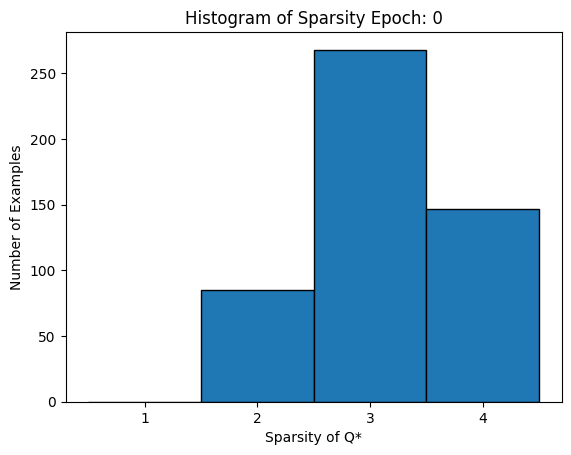

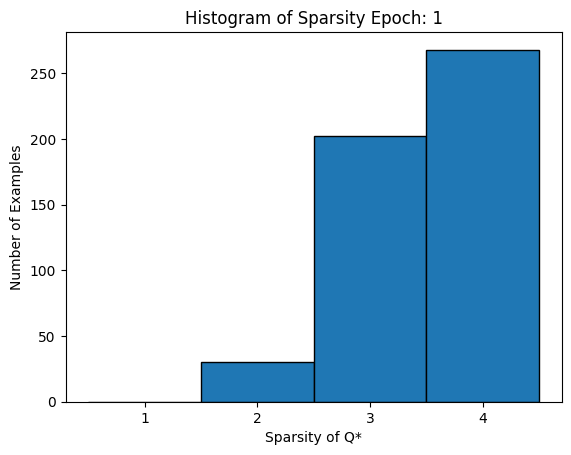

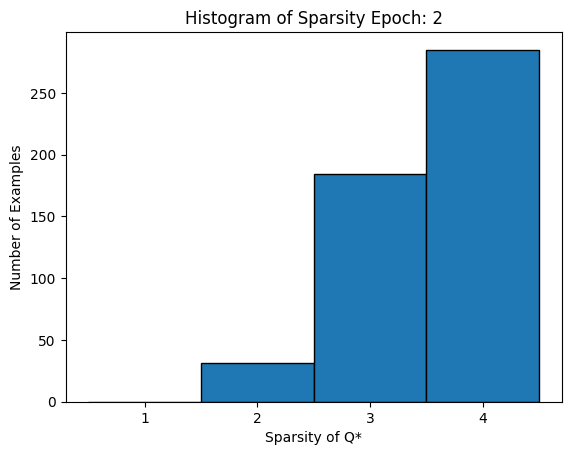

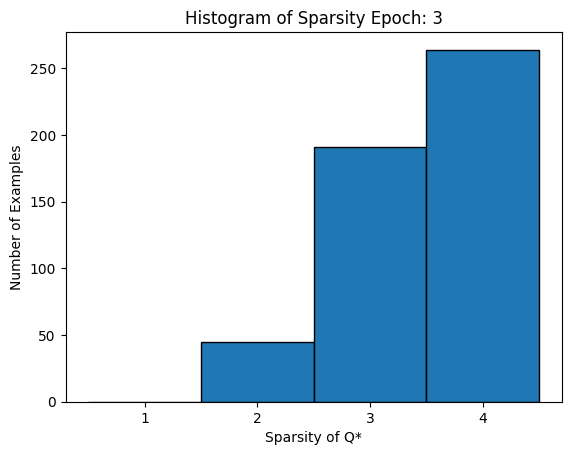

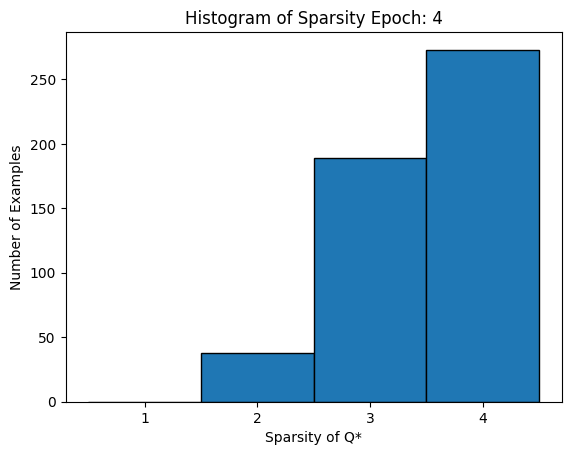

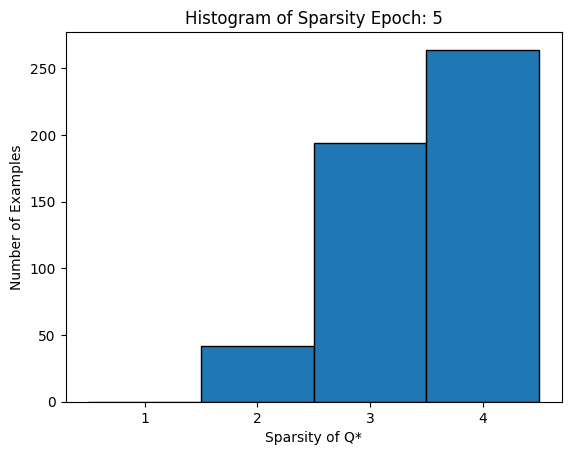

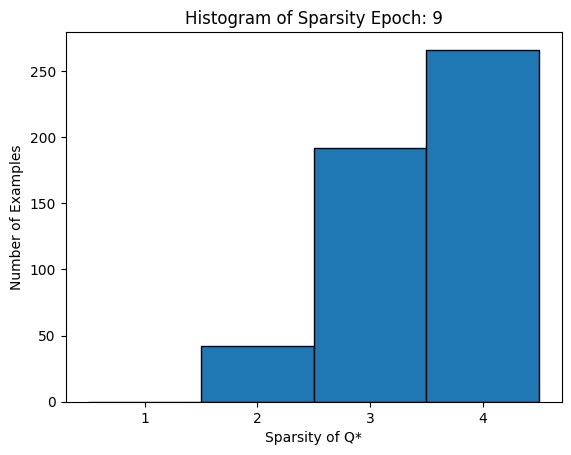

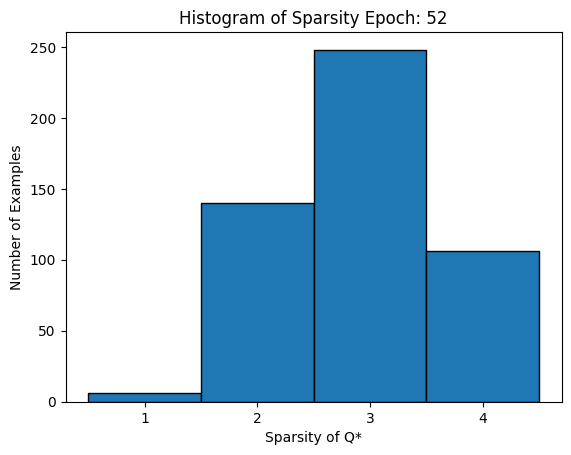

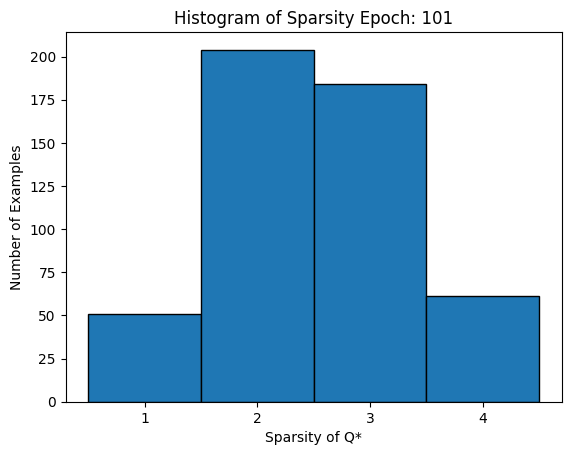

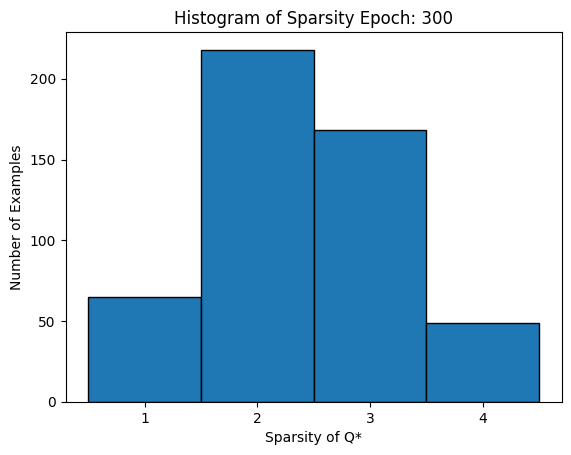

In [9]:
for load_epoch in epoch_list:

  # Load pretrained model from google drive
  checkpoint = torch.load(checkpoint_path + f'/vitb16_epoch={load_epoch}.pth', map_location=device)
  model.load_state_dict(checkpoint)

  # Set requires grad to fals for eval
  for param in model.parameters():
      param.requires_grad = False  # Freeze all parameters

  model.eval()

  # # Hook inputs of gate
  gate_inputs = []
  gate_outputs = []

  def hook_fn_inputs(module, input, output):
      # Ensure the function takes module, input, and output parameters
      gate_inputs.append(input[0].detach())
      gate_outputs.append(output)

  # Assuming model and imgs are correctly defined
  # Register the hook function
  hook = moe_layer.gate.register_forward_hook(hook_fn_inputs)

  # Pass images through the model
  model(imgs)

  hook.remove()

  # Calculate activations
  x = gate_inputs[0].squeeze()
  gscores = gate_outputs[0].squeeze()
  glogits = nn.functional.softmax(gscores,dim=1)

  # get top_k per row of gscores
  k_inds = torch.topk(gscores, k=top_k, dim=1).indices

  x_all = torch.stack([expert(x) for expert in moe_layer.experts]) # apply experts
  x_all = x[None,:,:] + x_all # residual connection
  x_all = model.encoder.ln(x_all) # layer_norm
  x_all = model.heads(x_all) # linear layer
  x_all = x_all.permute(1,0,2) # examples x experts x 10-logits (1000 x 3 x 10)
  # x_all = x_all.softmax(dim=2)

  sparsities = []

  for i in range(x_all.shape[0]):
    E = x_all[i].cpu().numpy()

    lam = cp.Variable(num_experts, nonneg=True)
    constraints = [lam.sum() == 1]
    onehot = np.zeros(E.shape[1])
    onehot[targets[i]] = 1
    obj = cp.sum_squares(E.T @ lam - onehot)
    prob = cp.Problem(cp.Minimize(obj), constraints = constraints)
    prob.solve()
    qstar = lam.value
    sparsities.append((qstar > 1e-6).sum())

  # Add labels to the middle of the bars
  counts, bins, patches = plt.hist(sparsities, bins=np.arange(1, num_experts+2) - 0.5, edgecolor='black')
  bin_centers = 0.5 * (bins[:-1] + bins[1:])

  # Set x-ticks at the middle of each bin
  plt.xticks(np.arange(1, num_experts+1))

  plt.xlabel("Sparsity of Q*")
  plt.ylabel("Number of Examples")
  plt.title(f"Histogram of Sparsity Epoch: {load_epoch}")
  plt.show()